# unit_id別 target_ym価格変化分析

同一 `unit_id` の物件が異なる `target_ym` でどの程度価格 (`money_room`) を変化させているかを調べるノートブックです。連続期間ペアごとの変化率や横ばいパターンを把握します。



In [4]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import japanize_matplotlib  # noqa: F401

pd.options.display.max_rows = 200
sns.set_theme(style="whitegrid")

ROOT = Path("/Users/takamiya/work/0000_repos/signate_comp_2nd")
TRAIN_PATH = ROOT / "data/raw/signate/train.csv"

usecols = [
    "unit_id",
    "target_ym",
    "money_room",
    "bukken_type",
    "bukken_id",
    "building_id",
    "full_address",
    "lon",
    "lat",
    "room_floor",
    "unit_area",
    "floor_plan_code",
]
df = pd.read_csv(TRAIN_PATH, usecols=usecols)
df = df.dropna(subset=["unit_id", "money_room"]).copy()
df["unit_id"] = df["unit_id"].astype("int64")
df["money_room"] = df["money_room"].astype(float)
df["target_ym"] = pd.to_datetime(df["target_ym"].astype(str), format="%Y%m")
df["type_label"] = df["bukken_type"].map({1202: "kodate", 1302: "mansion"})
for col in ["lon", "lat", "room_floor", "unit_area"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

print(f"rows loaded: {len(df):,}")
df.head()


rows loaded: 363,924


,target_ym,money_room,unit_id,bukken_type,type_label
0,2019-01-01,13980000.0,262186,1202,kodate
1,2019-01-01,24480000.0,35726,1202,kodate
2,2019-01-01,24480000.0,116820,1202,kodate
3,2019-01-01,16300000.0,281648,1202,kodate
4,2019-01-01,18800000.0,85898,1302,mansion


In [5]:
def mode_or_first(series: pd.Series):
    mode = series.mode(dropna=True)
    return mode.iloc[0] if not mode.empty else series.iloc[0]


agg_spec = {
    "price": ("money_room", "median"),
    "type_label": ("type_label", mode_or_first),
    "bukken_id": ("bukken_id", mode_or_first),
    "building_id": ("building_id", mode_or_first),
    "full_address": ("full_address", mode_or_first),
    "lon": ("lon", "median"),
    "lat": ("lat", "median"),
    "room_floor": ("room_floor", "median"),
    "unit_area": ("unit_area", "median"),
    "floor_plan_code": ("floor_plan_code", mode_or_first),
}

unit_target = (
    df.groupby(["unit_id", "target_ym"], as_index=False)
    .agg(**agg_spec)
    .sort_values(["unit_id", "target_ym"])
)

unit_target = unit_target.assign(
    prev_price=lambda d: d.groupby("unit_id")["price"].shift(),
    prev_target_ym=lambda d: d.groupby("unit_id")["target_ym"].shift(),
)

unit_target["months_diff"] = (
    unit_target["target_ym"].dt.to_period("M") - unit_target["prev_target_ym"].dt.to_period("M")
).apply(lambda p: p.n if p is not pd.NaT else pd.NA)

pairs = unit_target.dropna(subset=["prev_price", "prev_target_ym"]).copy()
pairs["price_diff"] = pairs["price"] - pairs["prev_price"]
pairs["pct_change"] = pairs["price"] / pairs["prev_price"] - 1
pairs["pair_label"] = (
    pairs["prev_target_ym"].dt.strftime("%Y-%m") + "→" + pairs["target_ym"].dt.strftime("%Y-%m")
)

pairs.head()


,unit_id,target_ym,price,type_label,prev_price,prev_target_ym,months_diff,price_diff,pct_change,pair_label
6,6,2020-01-01,160000000.0,kodate,160000000.0,2019-07-01,6,0.0,0.000000,2019-07→2020-01
10,11,2020-07-01,7800000.0,kodate,8300000.0,2020-01-01,6,-500000.0,-0.060241,2020-01→2020-07
13,14,2021-07-01,23800000.0,kodate,23800000.0,2021-01-01,6,0.0,0.000000,2021-01→2021-07
16,16,2019-07-01,28800000.0,mansion,24800000.0,2019-01-01,6,4000000.0,0.161290,2019-01→2019-07
17,16,2020-01-01,25900000.0,mansion,28800000.0,2019-07-01,6,-2900000.0,-0.100694,2019-07→2020-01


In [6]:
total_units = pairs["unit_id"].nunique()
total_pairs = len(pairs)
flat_pairs = (pairs["price_diff"] == 0).sum()

print(f"unit_id with >=2 target_ym: {total_units:,}")
print(f"pair comparisons: {total_pairs:,}")
print(f"flat (no change) pairs: {flat_pairs:,} ({flat_pairs / total_pairs:.1%})")

flat_units_share = pairs.groupby("unit_id")\
    ["price_diff"].apply(lambda s: (s == 0).any()).mean()
print(f"share of units that ever stay flat: {flat_units_share:.1%}")



unit_id with >=2 target_ym: 71,465
pair comparisons: 113,577
flat (no change) pairs: 51,289 (45.2%)
share of units that ever stay flat: 45.9%


In [7]:
consecutive_pairs = pairs[pairs["months_diff"] == 6].copy()
print(f"consecutive half-year pairs: {len(consecutive_pairs):,}")
print(f"flat share (consecutive only): {(consecutive_pairs['price_diff'] == 0).mean():.1%}")

pair_stats = (
    consecutive_pairs.groupby(["type_label", "prev_target_ym", "target_ym"])
    .agg(
        sample=("unit_id", "count"),
        median_pct=("pct_change", "median"),
        mean_pct=("pct_change", "mean"),
        zero_share=("price_diff", lambda x: (x == 0).mean()),
        pos_share=("price_diff", lambda x: (x > 0).mean()),
        neg_share=("price_diff", lambda x: (x < 0).mean()),
    )
    .reset_index()
)
pair_stats



consecutive half-year pairs: 106,143
flat share (consecutive only): 47.2%


,type_label,prev_target_ym,target_ym,sample,median_pct,mean_pct,zero_share,pos_share,neg_share
0,kodate,2019-01-01,2019-07-01,4771,0.000000,-0.039872,0.499057,0.029554,0.471390
1,kodate,2019-07-01,2020-01-01,8538,0.000000,-0.034609,0.464629,0.053291,0.482080
2,kodate,2020-01-01,2020-07-01,10671,0.000000,-0.032138,0.522819,0.030738,0.446444
3,kodate,2020-07-01,2021-01-01,9507,0.000000,-0.022803,0.574208,0.040391,0.385400
4,kodate,2021-01-01,2021-07-01,7857,0.000000,-0.013508,0.598829,0.049128,0.352043
5,kodate,2021-07-01,2022-01-01,7458,0.000000,-0.012500,0.579780,0.051622,0.368597
6,kodate,2022-01-01,2022-07-01,7371,0.000000,-0.018080,0.530864,0.064170,0.404965
7,mansion,2019-01-01,2019-07-01,7441,-0.032468,-0.025463,0.339874,0.085876,0.574251
8,mansion,2019-07-01,2020-01-01,8299,-0.029126,-0.024633,0.350163,0.083263,0.566574
9,mansion,2020-01-01,2020-07-01,8894,-0.029002,-0.029124,0.376321,0.064988,0.558691


/var/folders/xv/rygbbjfn1_3g64qmfrp_4_q40000gn/T/ipykernel_72572/1527390354.py:20: UserWarning: Glyph 36899 (\N{CJK UNIFIED IDEOGRAPH-9023}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xv/rygbbjfn1_3g64qmfrp_4_q40000gn/T/ipykernel_72572/1527390354.py:20: UserWarning: Glyph 32154 (\N{CJK UNIFIED IDEOGRAPH-7D9A}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xv/rygbbjfn1_3g64qmfrp_4_q40000gn/T/ipykernel_72572/1527390354.py:20: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xv/rygbbjfn1_3g64qmfrp_4_q40000gn/T/ipykernel_72572/1527390354.py:20: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xv/rygbbjfn1_3g64qmfrp_4_q40000gn/T/ipykernel_72572/1527390354.py:20: UserWarning: Glyph 12506 (\N{KATAKANA LETTER PE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xv/rygbbjfn1_3g64qmfrp_4_q40000gn/T/ipykernel

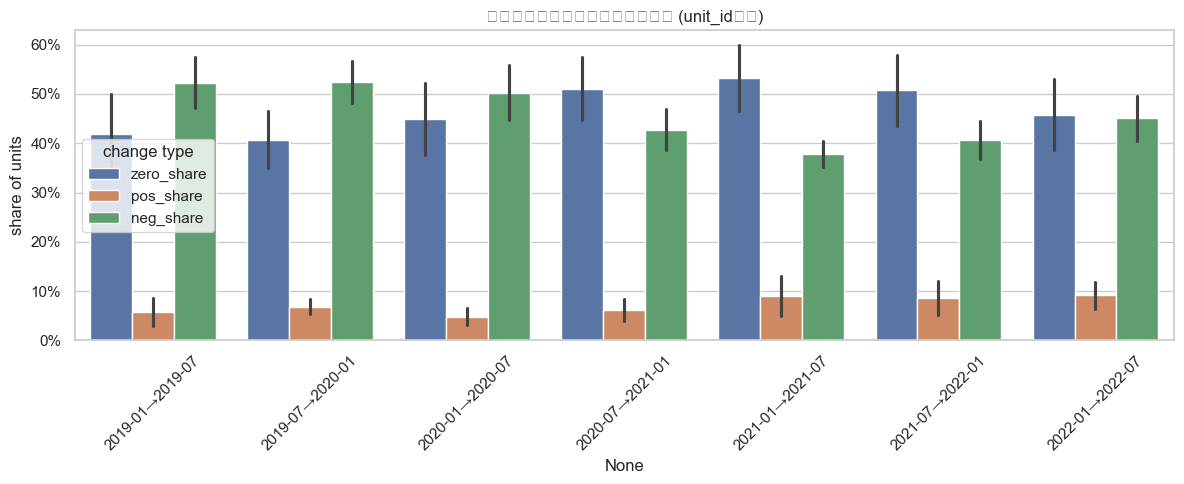

In [8]:
melted = pair_stats.melt(
    id_vars=["type_label", "prev_target_ym", "target_ym"],
    value_vars=["zero_share", "pos_share", "neg_share"],
    var_name="change_category",
    value_name="share",
)

plt.figure(figsize=(12, 5))
sns.barplot(
    data=melted,
    x=melted["prev_target_ym"].dt.strftime("%Y-%m") + "→" + melted["target_ym"].dt.strftime("%Y-%m"),
    y="share",
    hue="change_category",
)
plt.title("連続期間ペアごとの価格変化割合 (unit_id単位)")
plt.ylabel("share of units")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend(title="change type")
plt.tight_layout()
plt.show()



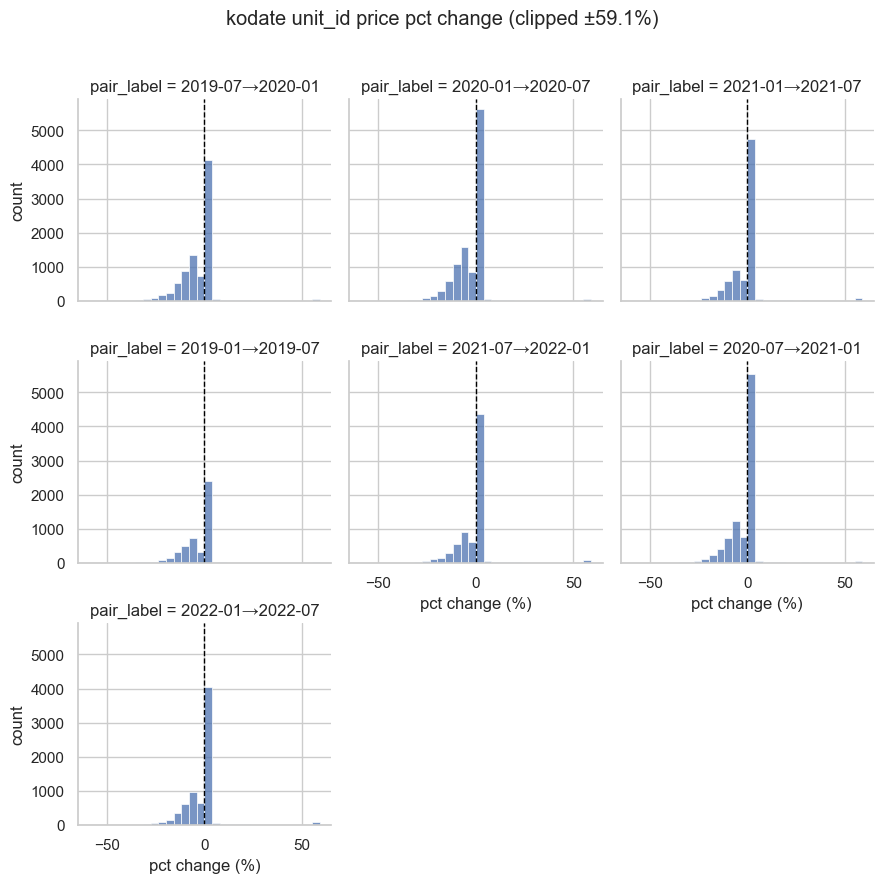

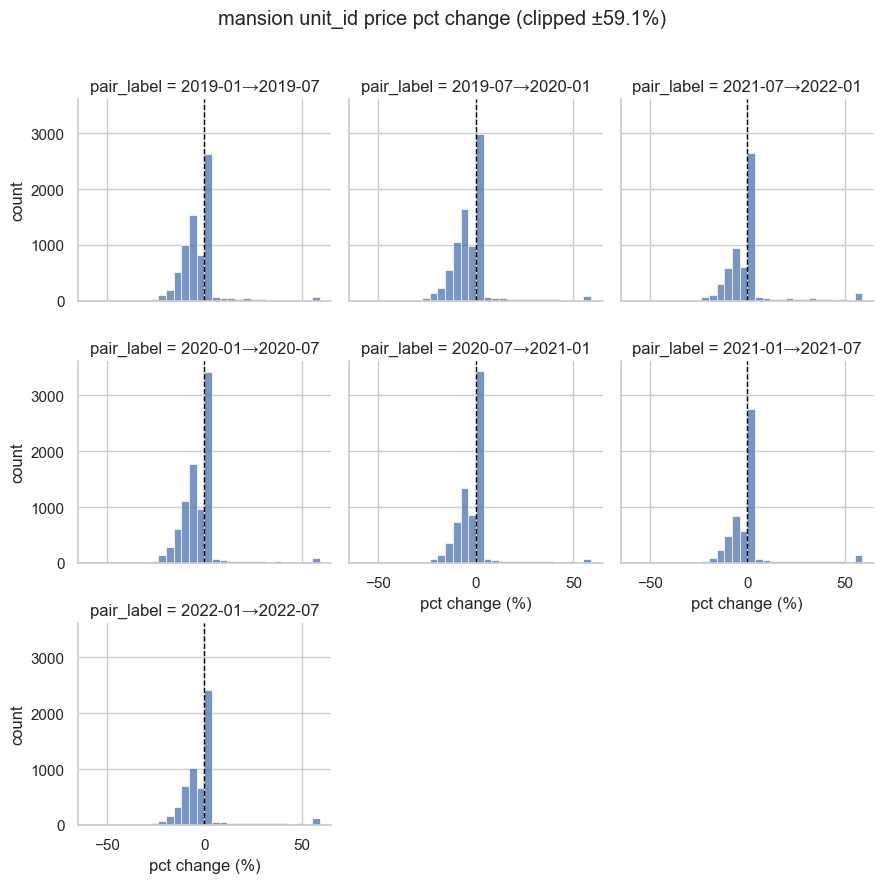

In [12]:
pair_hist = consecutive_pairs.copy()
pair_hist["pair_label"] = (
    pair_hist["prev_target_ym"].dt.strftime("%Y-%m")
    + "→"
    + pair_hist["target_ym"].dt.strftime("%Y-%m")
)
pair_hist["pct_change_pct"] = pair_hist["pct_change"] * 100

# 1〜99 percentileを参考に描画スケールを決め、極端な外れ値で潰れないようクリップ
clip_low, clip_high = pair_hist["pct_change_pct"].quantile([0.01, 0.99]).tolist()
clip_abs = min(200, max(abs(clip_low), abs(clip_high)))  # 200%を上限に制限
pair_hist["pct_change_pct_clipped"] = pair_hist["pct_change_pct"].clip(-clip_abs, clip_abs)

for type_label in sorted(pair_hist["type_label"].unique()):
    subset = pair_hist[pair_hist["type_label"] == type_label]
    g = sns.displot(
        data=subset,
        x="pct_change_pct_clipped",
        col="pair_label",
        col_wrap=3,
        kind="hist",
        bins=30,
        height=3,
        facet_kws={"sharex": True, "sharey": True},
    )
    for ax in g.axes.flatten():
        if ax is not None:
            ax.axvline(0, color="black", linestyle="--", linewidth=1)
    g.set_axis_labels("pct change (%)", "count")
    g.fig.subplots_adjust(top=0.88)
    g.fig.suptitle(
        f"{type_label} unit_id price pct change (clipped ±{clip_abs:.1f}%)",
        y=0.98,
    )
    plt.show()


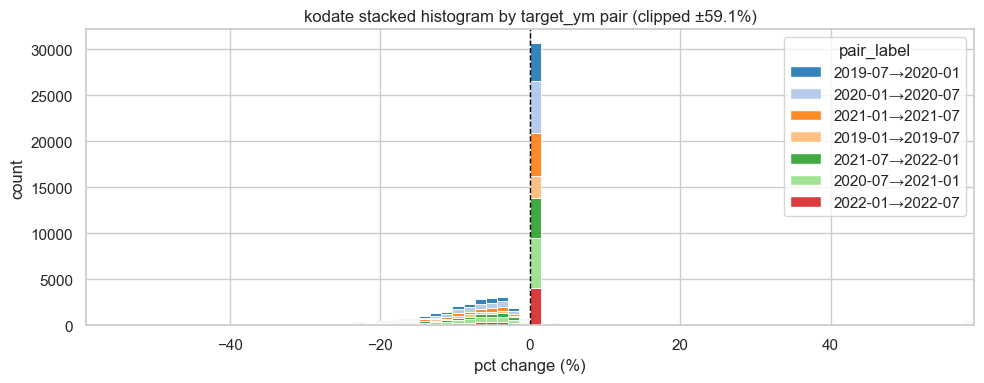

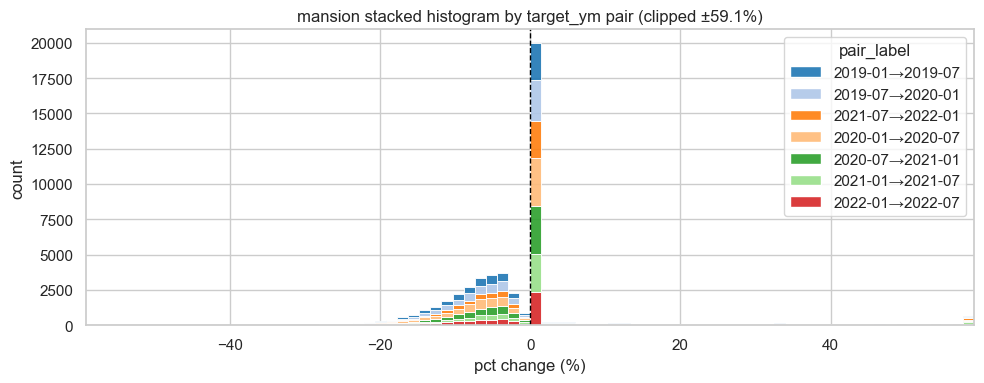

In [15]:
# pair_labelごとのヒストグラムをスタック表示（タイプ別）
for type_label in sorted(pair_hist["type_label"].unique()):
    subset = pair_hist[pair_hist["type_label"] == type_label]
    plt.figure(figsize=(10, 4))
    sns.histplot(
        data=subset,
        x="pct_change_pct_clipped",
        hue="pair_label",
        bins=80,
        multiple="stack",
        stat="count",
        palette="tab20",
        alpha=0.9,
    )
    plt.axvline(0, color="black", linestyle="--", linewidth=1)
    plt.xlim(-clip_abs, clip_abs)
    plt.xlabel("pct change (%)")
    plt.ylabel("count")
    plt.title(
        f"{type_label} stacked histogram by target_ym pair (clipped ±{clip_abs:.1f}%)"
    )
    plt.tight_layout()
    plt.show()



In [17]:
large_move_threshold = 0.50
large_moves = consecutive_pairs.loc[consecutive_pairs["pct_change"].abs() >= large_move_threshold].copy()
info_cols = [
    "unit_id",
    "target_ym",
    "bukken_id",
    "building_id",
    "full_address",
    "lon",
    "lat",
    "room_floor",
    "unit_area",
    "floor_plan_code",
]

available_info_cols = [col for col in info_cols if col in unit_target.columns]
extra_cols = [col for col in available_info_cols if col not in ["unit_id", "target_ym"]]
missing_cols = sorted(set(info_cols) - set(available_info_cols))
if missing_cols:
    print(f"Warning: missing columns in unit_target and excluded from listing: {missing_cols}")

current_info = unit_target[["unit_id", "target_ym"] + extra_cols].rename(
    columns={col: f"curr_{col}" for col in extra_cols}
)
large_moves = large_moves.merge(current_info, on=["unit_id", "target_ym"], how="left")

prev_info = (
    unit_target[["unit_id", "target_ym"] + extra_cols]
    .rename(columns={col: f"prev_{col}" for col in extra_cols})
    .rename(columns={"target_ym": "prev_target_ym"})
)
large_moves = large_moves.merge(prev_info, on=["unit_id", "prev_target_ym"], how="left")

large_moves["pct_change_pct"] = large_moves["pct_change"] * 100
large_moves = large_moves.sort_values("pct_change_pct", key=lambda s: s.abs(), ascending=False)

display_cols = [
    "unit_id",
    "type_label",
    "prev_target_ym",
    "target_ym",
    "prev_price",
    "price",
    "pct_change_pct",
]
for col in extra_cols:
    display_cols.extend([f"prev_{col}", f"curr_{col}"])

large_moves_display = large_moves[display_cols]

print(
    f"Pairs with ≥{large_move_threshold:.0%} move: {len(large_moves_display):,} "
    f"(units: {large_moves_display['unit_id'].nunique():,})"
)
large_moves_display.head(200)


Pairs with ≥50% move: 1,536 (units: 1,512)


,unit_id,type_label,prev_target_ym,target_ym,prev_price,price,pct_change_pct
156,28547,kodate,2021-07-01,2022-01-01,9800000.0,160000000.0,1532.653061
848,180026,kodate,2021-01-01,2021-07-01,29000000.0,180000000.0,520.689655
987,209553,kodate,2021-01-01,2021-07-01,5800000.0,30000000.0,417.241379
130,23152,kodate,2021-01-01,2021-07-01,29000000.0,148000000.0,410.344828
612,132477,kodate,2022-01-01,2022-07-01,6000000.0,29800000.0,396.666667
1152,244075,kodate,2020-01-01,2020-07-01,8800000.0,39900000.0,353.409091
236,49309,kodate,2019-01-01,2019-07-01,5000000.0,18800000.0,276.000000
261,54250,kodate,2020-07-01,2021-01-01,5800000.0,21800000.0,275.862069
1400,298809,kodate,2020-01-01,2020-07-01,11000000.0,39800000.0,261.818182
1172,248690,kodate,2020-01-01,2020-07-01,12000000.0,42300000.0,252.500000


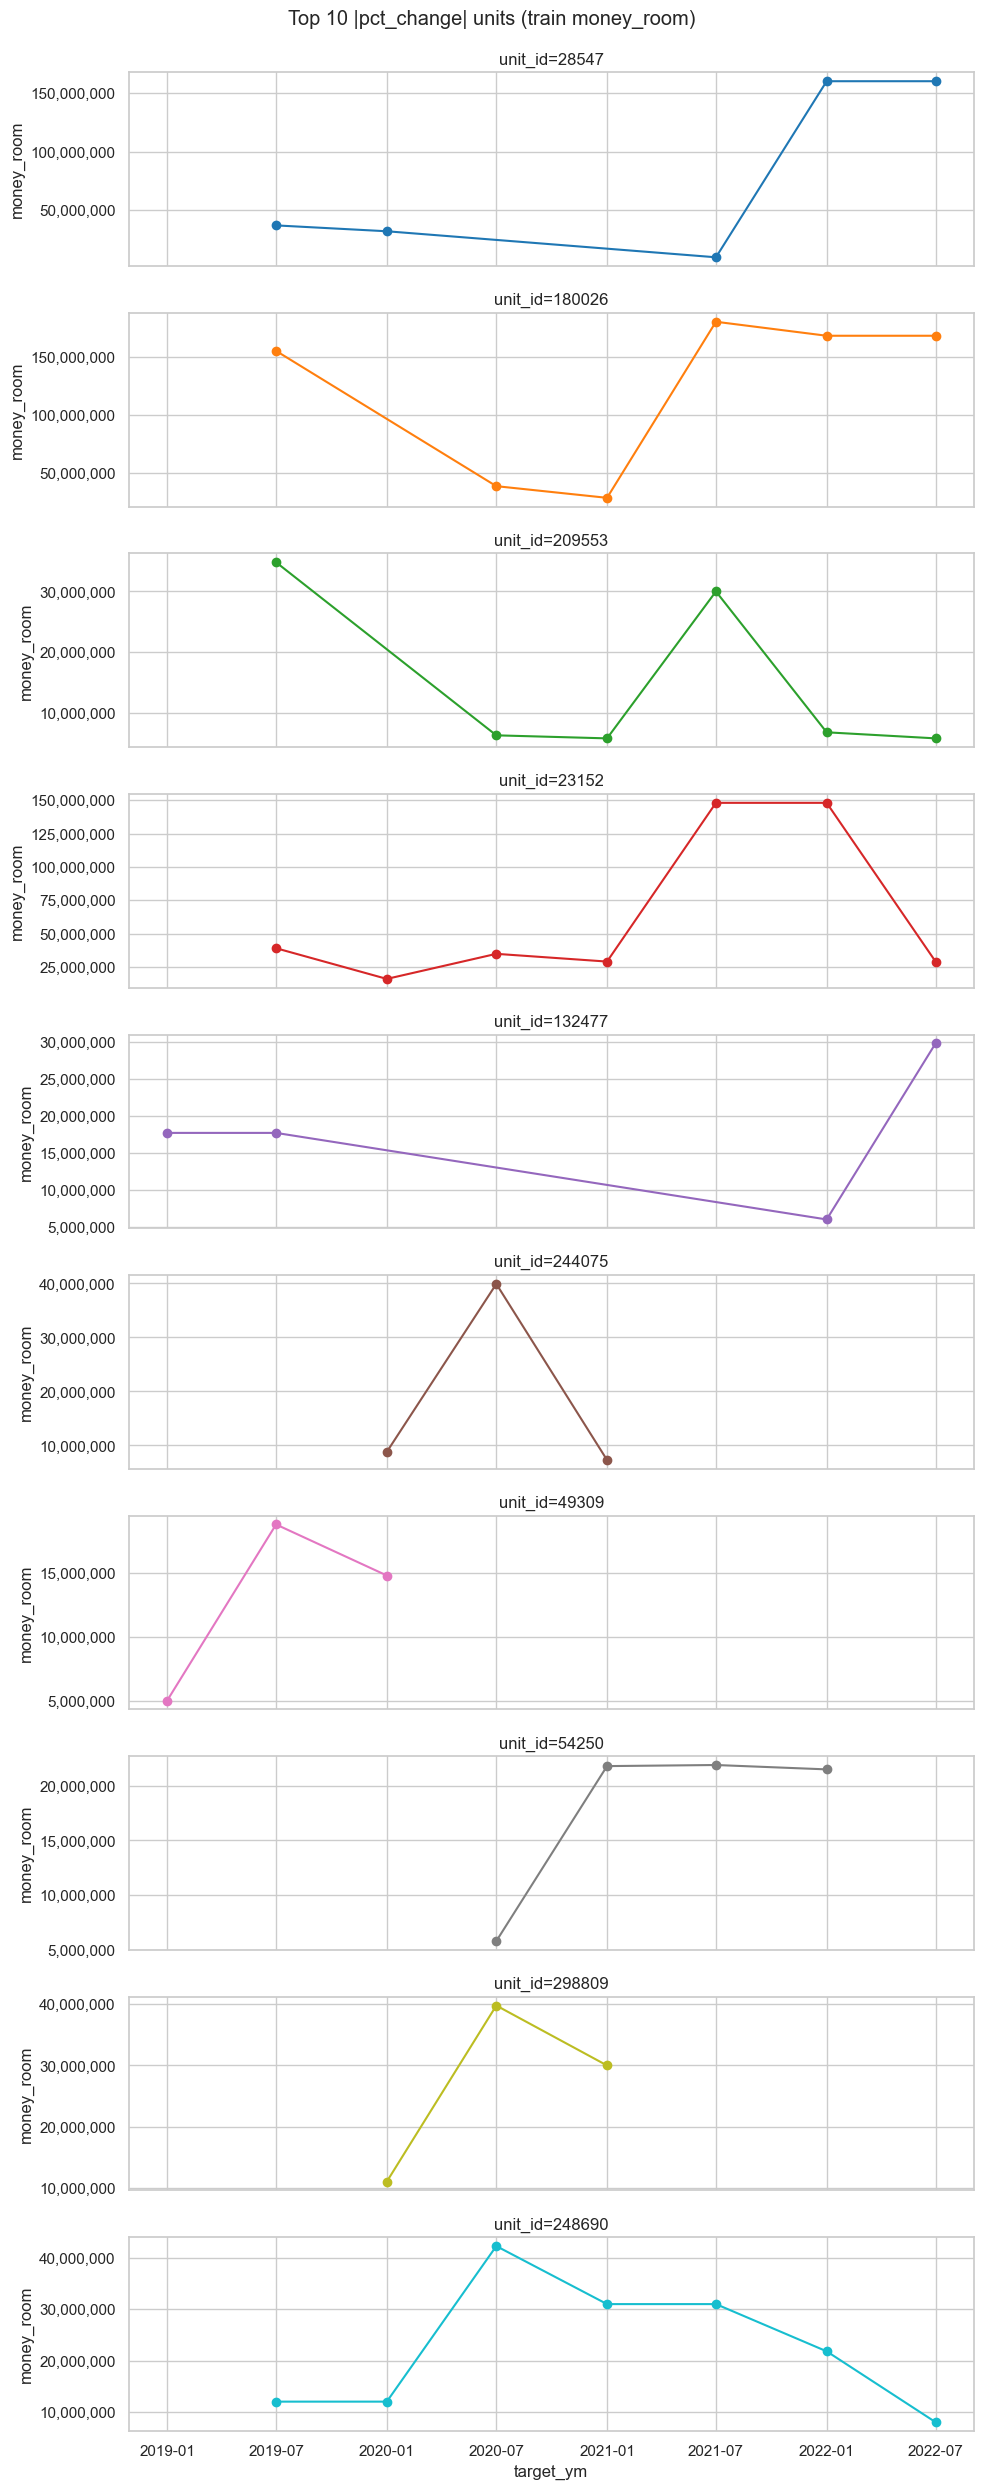

In [19]:
# 変化率上位ユニットの時系列推移
move_top10 = large_moves.sort_values("pct_change_pct", key=lambda s: s.abs(), ascending=False)     .head(10)["unit_id"].unique()

top_units = df[df["unit_id"].isin(move_top10)].copy()
if not pd.api.types.is_datetime64_any_dtype(top_units["target_ym"]):
    top_units["target_ym"] = pd.to_datetime(top_units["target_ym"], errors="coerce")
top_units = top_units.dropna(subset=["target_ym"]).sort_values(["unit_id", "target_ym"])

palette = sns.color_palette("tab10", n_colors=len(move_top10))
unit_to_color = {u: palette[i % len(palette)] for i, u in enumerate(move_top10)}

fig, axes = plt.subplots(len(move_top10), 1, figsize=(10, 2.5 * len(move_top10)), sharex=True)
if len(move_top10) == 1:
    axes = [axes]

for ax, unit_id in zip(axes, move_top10):
    series = top_units[top_units["unit_id"] == unit_id]
    ax.plot(series["target_ym"], series["money_room"], marker="o", color=unit_to_color[unit_id])
    ax.set_title(f"unit_id={unit_id}")
    ax.set_ylabel("money_room")
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

axes[-1].set_xlabel("target_ym")
fig.suptitle("Top 10 |pct_change| units (train money_room)", y=0.995)
plt.tight_layout()
plt.show()


In [9]:
pct_summary = consecutive_pairs["pct_change"].describe(percentiles=[0.25, 0.5, 0.75])
pct_summary


count    106143.000000
mean         -0.018904
std           0.145146
min          -0.902778
25%          -0.067016
50%           0.000000
75%           0.000000
max          15.326531
Name: pct_change, dtype: float64

In [10]:
pair_pct_table = (
    consecutive_pairs.groupby(["prev_target_ym", "target_ym"])["pct_change"]
    .agg(count="count", mean="mean", median="median", std="std")
)
pair_pct_table


,,count,mean,median,std
prev_target_ym,target_ym,,,,
2019-01-01,2019-07-01,12212,-0.031092,-0.02401,0.123345
2019-07-01,2020-01-01,16837,-0.029692,-0.01938,0.124658
2020-01-01,2020-07-01,19565,-0.030768,0.00000,0.118068
2020-07-01,2021-01-01,17066,-0.017512,0.00000,0.123052
2021-01-01,2021-07-01,13591,-0.002625,0.00000,0.161627
2021-07-01,2022-01-01,13437,-0.003450,0.00000,0.204311
2022-01-01,2022-07-01,13435,-0.010726,0.00000,0.156127
